<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>MNIST ANN</center></b>
</div>

# Configure Learning Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Prepare Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
res_train = datasets.MNIST("./datas", train=True, transform=transform, download=True)

In [5]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=100, shuffle=True)

In [6]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

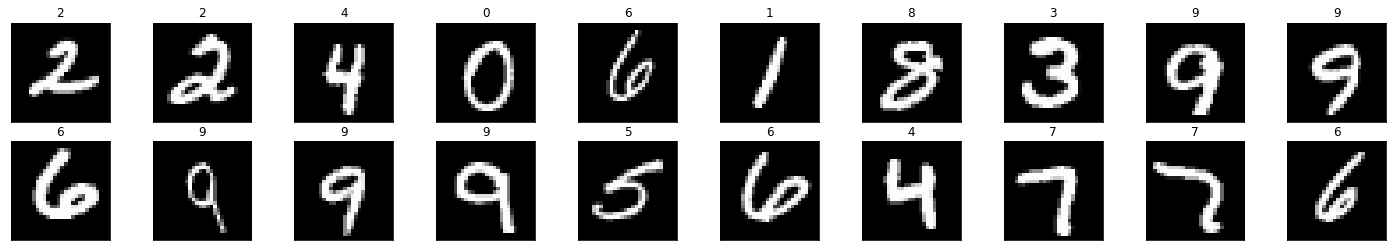

In [8]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

# Generate Model

In [9]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        x = self.activate1(self.linear1(x))
        x = self.activate2(self.linear2(x))
        x = self.linear3(x)
        return x

In [10]:
model = Classifier(784, 125, 65, 10).to(device)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (activate1): ReLU()
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (activate2): ReLU()
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [11]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [12]:
epochs = 20
amount_batch = len(load_train)

In [13]:
history = []
for epoch in range(epochs):
    loss_learns = .0
    accu_learns = .0
    
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        inputs = datas.view(datas.shape[0], -1)
        preds = model(inputs)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
        
    loss_learn = loss_learns / amount_batch
    accu_learn = accu_learns / amount_batch
    history.append({"loss": loss_learn, "accuracy": accu_learn})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %")

01 step -> loss: 0.9546, accuracy: 76.49 %
02 step -> loss: 0.3816, accuracy: 89.30 %
03 step -> loss: 0.3231, accuracy: 90.77 %
04 step -> loss: 0.2919, accuracy: 91.53 %
05 step -> loss: 0.2652, accuracy: 92.32 %
06 step -> loss: 0.2423, accuracy: 92.99 %
07 step -> loss: 0.2239, accuracy: 93.50 %
08 step -> loss: 0.2061, accuracy: 94.11 %
09 step -> loss: 0.1924, accuracy: 94.47 %
10 step -> loss: 0.1791, accuracy: 94.82 %
11 step -> loss: 0.1672, accuracy: 95.17 %
12 step -> loss: 0.1563, accuracy: 95.48 %
13 step -> loss: 0.1477, accuracy: 95.69 %
14 step -> loss: 0.1381, accuracy: 95.96 %
15 step -> loss: 0.1303, accuracy: 96.16 %
16 step -> loss: 0.1234, accuracy: 96.36 %
17 step -> loss: 0.1169, accuracy: 96.55 %
18 step -> loss: 0.1107, accuracy: 96.81 %
19 step -> loss: 0.1054, accuracy: 96.97 %
20 step -> loss: 0.0996, accuracy: 97.14 %


array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

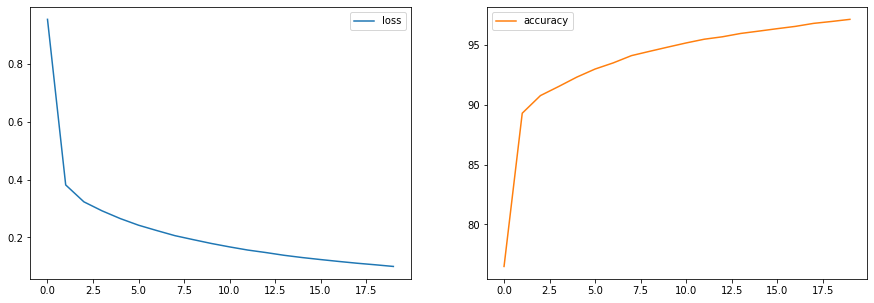

In [14]:
df_history = pd.DataFrame.from_records(history)
df_history.plot(subplots=True, layout=(1, 2), figsize=(15, 5))